In [1]:
"""MgH+ Polaritonic Potential Energy Surfaces"""

__authors__ = ["Jonathan J. Foley"]
__email__   = ["jfoley19@uncc.edu"]
__credits__ = ["Jonathan J. Foley"]
__copyright__ = "(c) 2008-2020, The Psi4Education Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-02-11"

In [2]:
### Import libraries to be used throughout
# basic psi4 library
import psi4
# numpy
import numpy as np
# scipy
from scipy.interpolate import InterpolatedUnivariateSpline
# linear algebra package from numpy
from numpy import linalg as LA
# time-dependent scf library from psi4 for computing excited states and transition dipole moments
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
#from matplotlib import pyplot as plt

## Polaritonic chemistry for a simple diatomic molecule strongly interacting with light

#### Learning Objectives

- Students will be able to define a molecular polariton

- Students will be able to explain how forming molecular polaritons can modify chemical structure and reactivity

- Students will be able to use quantum chemistry calculations to parameterize a Rabi model Hamiltonian for a molecular polariton

- Students will be able to construct polaritonic potential energy surfaces using the Rabi model

- Students will be able to estimate a qualitative relationship between the coupling strength and splitting between polaritonic potential energy surfaces

#### Supplementary learning objective

- Students will be able to apply the rules of 2nd quantized operators to derive the Rabi Hamiltonian matrix

#### Background
Nanostructured materials can be designed to strongly confine light down to nanoscale dimensions, which 
greatly enhances the energy density of light and increases its interaction with molecular excitations.
When molecules through their excitations *strongly* interact with light, new quantum states, called polariton states, emerge that have
properties of light and of matter.  

Consider the image below that shows the MgH+ molecule strongly 
interacting with a nanoconfined photon trapped between two parallel mirrors (aka a cavity). This cavity 
confines a photon with electric field $\vec{E}$ aligned with the transition dipole moment $\vec{\mu}_{i\rightarrow f}$  connecting the ground to first singlet excited state of MgH+.  When the energy of the trapped photon ($\hbar \omega$) matches this excitation energy in a particular region of the MgH+ potential energy surface, energy can be 
rapidly exchanged between the molecular excitation and the cavity.  We can think of this exchange as cylcing between  the molecule absorbing the trapped photon and becoming excited, and relaxing back to the ground-state and emitting the a photon which becomes trapped in the cavity.  When this cycling is rapid, as is the case when the interaction 
is strong, the cycling of energy makes it impossible to distinguish between the quantum state of the excited molecule and the quantum state of the photon localized in the cavity.  Rather, we think of this situation as a hybrid state that is part light part matter, and we call this state a polariton.  One fascinating feature of molecular polaritons
is that their potential energy surfaces may be dramatically different than the potential energy surfaces of their
molecular constituents.  Consequently, new and different chemical reactivity may be realized by putting molecules in cavities!  This notebook will explore the reshaping of the potential energy surfaces of the simple diatomic
MgH+ by placing it in a cavity.

<img src="data/MgH_polariton.png" width=300 height=300 />
 



##### What is a molecular polariton?

A *molecular polariton* can be understood as quantum state that mixes the quantum states of a photon and the quantum states of a molecule.  The two criteria for forming a molecular polariton are that

1. The photon energy should match the transition energy between molecular quantum states

2. The energy scale of the interaction between the photon and the molecular transition should be large compared to dissipation energy scales in the individual molecular and photonic systems




**Question 1** Let's consider the first criteria for electronic transitions in the MgH+ system.  The the relevant electronic transition (ground to first singlet excited state) energy is on the order of 4 eV.  What photon wavelength can be used to form a molecular polariton with this electronic transition assuming a transition energy of 4 eV?

*Answer goes here!* 

*Hint:* $ E = \hbar \omega $ and $ \lambda = \frac{2\pi c}{\omega} $  

In [3]:
transition_energy = 4.0 # g -> e transition energy in eV

hbar_eV_s = 6.582119569e-16 # -> hbar in eV * s

c_SI = 299792458 # -> speed of light in m / s

m_to_nm = 1e9 # -> conversion between meters and nanometers

# ==> Write code to compute wavelength in meters here <==
omega_SI = transition_energy / hbar_eV_s

lambda_SI = np.pi * 2 * c_SI / omega_SI

# ==> Write code to convert wavelength from meters to nanometers here... store in variable lambda_nm <==
lambda_nm = lambda_SI * m_to_nm

print(f'The photon wavelength is {lambda_nm:.3f} nm')

The photon wavelength is 309.960 nm


Let's consider the second criteria that the interaction energy scale must be large compared to the dissipation energy scales of the individual molecular and photonic system. Specifically, we have the criteria 
$$ \hbar g > \hbar \frac{\gamma_p + \gamma_m}{4} \tag{1}$$ 
where $\hbar g$ represents the interaction energy scale, $\hbar \gamma_p$ represents the dissipation energy scale of the photon and $\hbar \gamma_m$ represents the dissipation energy scale of the molecular excitation.  These $\gamma$ terms represent dissipation rates, and can be interpreted as the inverse of the lifetime of the occupation of the photon in the cavity in the case of $\gamma_p$ or the inverse of the lifetime of an electronic excitation in the case of $\gamma_m$.  Typically, $\gamma_p >> \gamma_m$ so we will assume that $\gamma_p + \gamma_m \approx \gamma_p $ for the analysis that follows.

We can define $g$ as follows:

$$ g = \sqrt{ \frac{\omega}{2}} \lambda \cdot \mu_{ge}, \tag{2}$$
where the fundamental coupling strength $\lambda$ is defined as 
$$ \lambda = \sqrt{\frac{1}{\epsilon_0 V}}, \tag{3}$$
$\mu_{eg}$ is the transition dipole moment associated with the electronic transition, and 
$V$ represents the volume of the cavity that confines the photon (and molecule).  Here we can
see that for a given value of the transition dipole moment, increasing the confinement of the photon by decreasing $V$ increases the interaction energy scale by increasing the fundamental coupling strength $\lambda$. 

**Question 2**
If we can assume that (in atomic units) $\mu_{ge} = 1$, $\omega = 0.1469$, and $\gamma_p = 0.0016$, what is the value of $V$ required to satisfy $g = \frac{\gamma_p}{4}$? 

*Answer goes here!* 


*Hint:* In atomic units, $\frac{1}{\epsilon_0} = 4 \pi$.

In [4]:
mu_ge_au = 1 # -> transition dipole moment in atomic units 

gamma_p_au = 0.0016 # -> photon dissipation rate in atomic units

omega_au = 0.1469 # -> photon frequency in atomic units

au_to_nm = 0.0529 # -> conversion factor for atomic units of length to nanometers

# ==> Write code to compute V in atomic units here <== 
V_au = 4 * np.pi / (gamma_p_au / (4 * mu_ge_au * np.sqrt(omega_au / 2) ) ) ** 2
print(V_au)
# ==> Convert volume in atomic units to volume in nm^3 <==
V_nm = V_au * au_to_nm ** 3

print(f'The cavity volume is {V_nm:.3f} nm^3')

5768749.5101542575
The cavity volume is 853.982 nm^3


#### Model system
We will consider the diatomic cation MgH+ in a cavity chosen such that it can trap a photon with a 
frequency of $\hbar \omega = 4.3$ eV. 
We will compute the singlet ground state and first singlet excited state potential energy surfaces along the
Mg-H+ stretch coordinate $R$ using density functional theory (DFT) and time-dependent density functional theory (TDDFT), respectively.  DFT provides an efficient method for computing the ground-state energy of a quantum mechanical system using the electron density (rather than the wavefunction) as the primary variable, and TDDFT provides an efficient method for estimating the energies and properties of excited-states starting from the DFT ground state.    We denote the ground 
state ket as $|g\rangle$ with an associated energy eigenvalue $E_g(R)$, and the excited-state $|e\rangle$
with associated energy eigenvalue $E_e(R)$ where $R$ is the bondlength.  The transition dipole
moment between $|g\rangle$ and $|e\rangle$ will also be computed using TDDFT, yielding $\mu_{ge}(R)$. 
While
the transition dipole moment and the electric field are vector quantities, in this case $\mu_{ge}(R)$ is oriented along the internuclear coordinate ($R$), and so for simplicity we consider an electric field oriented soley along
$R$ as well and treat both quantities as scalars.

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$, and 1 photon in the cavity $|1\rangle$.  The photon has an energy of $\hbar \omega$. At the same time, we will allow for the molecule to be in its electronic ground state $|g\rangle$ or its first electronic excited state $|e\rangle$.  
This leads to the following basis states for the composite system:

$|g,0\rangle \rightarrow$ The molecule is in the ground state and there is no photon in the cavity.

$|g,1\rangle \rightarrow$ The molecule is in the ground state and there is one photon in the cavity.

$|e,0\rangle \rightarrow$ The molecule is in its first electronic excited state and there is no photon in the cavity.

We will neglect the $|e,1\rangle$ state for simplicity, and if desired, it can be shown that its inclusion does not impact the results.

In this 3-state basis, we will model this system with a generalized Rabi Hamiltonian that can be written as:
\begin{equation}
    {\bf H} =
    \begin{pmatrix}
    E_g(R)  & 0 & 0 \\
    0 & E_g(R) + \hbar \omega &  \lambda \cdot \mu_{ge}(R) \\
    0 &  \lambda \cdot \mu_{ge}(R) & E_e(R)
    \end{pmatrix}. \tag{4}
\end{equation}
where $E_g(R)$ denotes the ground-state potential energy surface, i.e. the energy of state $|g\rangle$ at bondlength $R$, $E_e(R)$ denotes the potential energy surface of the first excited state (energy of state $|e\rangle$ at bondlength $R$), and $\mu_{ge}(R)$ denotes the transition dipole moment between state $|g\rangle$ and $|e\rangle$.  Applying second quantized operators to derive this Hamiltonian matrix is supplementary learning outcome; interested students are directed to [Derivation](#Derivation) cell for the derivation.

We can see that the molecular and photonic basis states interact with each other (i.e. the Hamiltonian in this basis is not diagonal).  We can diagonalize this matrix to yield the *polaritonic* states.  We will 
use the following nomenclature for these eigenpairs that define these polaritonic states:

$E_g|\psi_g\rangle \rightarrow$ The ground-state energy and eigenstate of the interacting system, which is approximately equal to $E_g$ and $|g,0\rangle$ from before.  This corresponds to the lowest eigenvalue of the Rabi Hamiltonian.

$E_{LP}|\psi_{LP}\rangle \rightarrow$ The lower-polariton energy and eigenstate.  The lower-polariton eigenstate is a linear 
combination of the $|g,1\rangle$ and $|e,0\rangle$ states.  This corresponds to the second-lowest eigenvalue of the Rabi Hamiltonian.

$E_{UP}|\psi_{UP}\rangle \rightarrow$ The upper-polariton energy and eigenstate.  The upper-polariton eigenstate is also a linear 
combination of the $|g,1\rangle$ and $|e,0\rangle$ states.  This corresponds to the third-lowest eigenvalue of the Rabi Hamiltonian (or highest eigenvalue in the case we are using only the 3 basis states defined above).



##### Procedure
We will build and diagonalize this matrix across a range of bondlength values ($R$), and the 
resulting eigenvalues will comprise the polaritonic potential energy surfaces.  The resulting 
eigenvectors will comprise the polaritonic energy eigenstates.  We will utilize the `psi4` package to compute
$E_g(R)$, $E_e(R)$, and $\mu_{ge}(R)$ to be used in the model Hamiltonian above.

We will import psi4 to have access to the DFT engine for computation of ground-state properties, and the scf_response library of psi4 to have access to TDDFT methods for obtaining excited-state properties.  We will also import numpy and scipy libraries to help with constructing and diagonalizing the Rabi Hamiltonian.

To compute $E_g(R)$, $E_e(R)$, and $\mu_{ge}(R)$, we will use DFT/TDDFT at the B3LYP/cc-pVDZ level for 25 different geometries from $R = 1.1$ to $R = 3.5$ Angstroms.

The scan of different $R$ values uses similar syntax as has been demonstrated in other Psi4Education labs, see for example the lab on the [calculation of spectroscopic constants](https://github.com/Psi4Education/psi4education/blob/master/labs/spectroscopic_constants/spectroscopic_constants_student.ipynb).

Extracting the excitation energy and the transition dipole moment requires that we run the `tdscf_excitations` method from the psi4 package, which we have explicitly imported.  This method returns a dictionary containing different information about the excited-state energies and properties. 

##### The tdscf_excitations method and dictionary
The syntax for computing singlet excited-state properties with the tdscf_excitations method is as follows:

`res = tdscf_excitations(wfn, states=n, triplets='None')`

where `wfn` is the wavefunction object that can be obtained from a prior ground-state calculation, `states=n` specifies the number `n` of excited-states you wish to compute, `triplets='None'` specifies that only singlet exited states will be obtained, and `res` is the name specified for the nested dictionary that the method returns to store the excited-state information.  

Dictionaries are used to store data values in key:value pairs, and nested dictionaries have multiple dictionaries inside a dictionary.  This construction is useful for the excited-state calculations because there are many excited states, each having properties that can be specified by the same key.   

We are interested in two keys for our calculation.
The key `"EXCITATION ENERGY"` can be used to access the excitation energy from the ground state to a given excited state obtained from the calculation, and the key `"ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"` can be used to access the transition dipole moments associated with the computed states (ground-to-excited state only).  Because we are interested in these properties only for the first excited state, we will access them as follows:

`res[0]["EXCITATION ENERGY"]`: $E_e(R) - E_g(R)$

`res[0]["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"]`: $\mu_{ge}(R)$.

Information about the second excited-state would be obtained from keys associated with `res[1]['KEY']`, etc.

To see all of the keys of the nested dictionary called `res`, you can type `res[0].keys()`.   For a more general discussion of nested dictionaries, see [here](https://www.programiz.com/python-programming/nested-dictionary).


In [5]:
# set basis
psi4.set_options({
    'basis':'cc-pVDZ'
})

# set the number of electronic states... this is the ground state + n_states more
# we will get 1 excited-state
n_states = 1

# set the number of bond lengths to compute the stretch along
n_geoms = 25

# initialize geometry list
geoms = []

# initialize energy list... note
# there will be the ground state energy + n_states excited state energies
Es = np.zeros((n_states+1, n_geoms))

# initialize z-component of transition dipole list
mu_z = np.zeros((n_states, n_geoms))

# generate bond lengths
rs = []
for i in range(0,n_geoms):
    rs.append(1.1 + i*0.1)

# loop over bond lengths
ctr = 0
for i in rs:
    # generate the MgH+ molecule using a z-matrix and set the Mg-H+ bond length
    mol = psi4.geometry("""
    Mg
    H 1 """ + str(i) + """
    symmetry c1
    1 1
    """)
    # save the geometry
    geoms.append(mol.geometry().to_array())
    psi4.set_options({
    'save_jk': True,
    })  
   
    # calculate and save the ground-state energy and wavefunction
    e, wfn = psi4.energy("b3lyp/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # calculate the excited-state energies and save them to a dictionary called 'res'
    # !!! Insert a markdown section that explains the syntax of the tdscf_excitations method
    #     pay particular attention to explaining the dictionary because it is not
    #     a requisite python skill...
    #     also tell the user how to see all the keys by printing the entire dictionary!
    res = tdscf_excitations(wfn, states=n_states, triplets = "NONE")
    
    # parse the excitation energies from the 'res' dictionary 
    delta_e = [r["EXCITATION ENERGY"] for r in res]
    
    # parse the transition dipole moment from the 'res' dictionary
    mu = [r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"] for r in res]
    Es[0,ctr] = e
    
    # store the results to the respective arrays
    for j in range(0, n_states):
        Es[j+1,ctr] = e + delta_e[j]
        # !!! explain we only want the z-component which is index 2!
        mu_z[j,ctr] = mu[j][2]
    # print if you want to
    # print(i, Es[:,ctr])
    
    # increment the counter!
    ctr += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Mon May 22 16:04:33 2023

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry MG         line   353 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/cc-pvdz.gbs 
    atoms 2 entry H          line    22 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RKS Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------



******************************************************************************************
**********                               WARNING                                **********
**********       The names of excited state variables changed between 1.5       **********
**********     and 1.6. For a quick solution, remove the symmetry specifier     **********
**********   from the variable name. For full details, see 'Notes on Psivars'   **********
**********                        in the documentation.                         **********
******************************************************************************************



         ---------------------------------------------------------
                         TDSCF excitation energies                
                 by Andrew M. James and Daniel G. A. Smith        
         ---------------------------------------------------------

  ==> Options <==

     Residual threshold  : 1.0000e-04
     Initial guess       : denomi

   @DF-RKS iter SAD:  -200.41641446231034   -2.00416e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.26598276716948    1.50432e-01   7.95163e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.27438543628222   -8.40267e-03   6.71892e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.30817252340483   -3.37871e-02   4.89727e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.30835491290713   -1.82390e-04   1.57826e-05 DIIS
   @DF-RKS iter   5:  -200.30835505508034   -1.42173e-07   2.71089e-06 DIIS
   @DF-RKS iter   6:  -200.30835505827457   -3.19423e-09   3.26929e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999998606 ; deviation = -1.394e-07 

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A    -47.134218     2A     -3.426142     3A     -2.172938  
       4A     -2.166785     5A     -2.166785     6A     -0.559525  

    Virtual:                

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number of Cartesian functions: 162
    Spherical Harmonics?: true
    Max angular momentum: 4

  Cached 100.0% of DFT collocation blocks in 0.029 [GiB].

  Minimum eigenvalue in the overlap matrix is 9.7196407703E-03.
  Reciprocal condition number of the overlap matrix is 2.9793790533E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: S

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.39498364364954   -2.00395e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.32504595186739    6.99377e-02   7.22139e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.32506475480872   -1.88029e-05   6.82192e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.36414383205536   -3.90791e-02   4.71428e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.36433920744150   -1.95375e-04   1.34722e-05 DIIS
   @DF-RKS iter   5:  -200.36433934431207   -1.36871e-07   3.62571e-06 DIIS
   @DF-RKS iter   6:  -200.36433935201285   -7.70078e-09   4.04911e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999999989 ; deviation = -1.072e-09 

  

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.38518309771894   -2.00385e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.33792111163456    4.72620e-02   6.88719e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.33171515095989    6.20596e-03   7.05048e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.37590024084929   -4.41851e-02   4.50100e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.37609126525246   -1.91024e-04   1.42711e-05 DIIS
   @DF-RKS iter   5:  -200.37609143416864   -1.68916e-07   4.51434e-06 DIIS
   @DF-RKS iter   6:  -200.37609144745295   -1.32843e-08   3.88867e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999999544 ; deviation = -4.557e-08 

  

   @DF-RKS iter SAD:  -200.37619012740791   -2.00376e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.34383523816015    3.23549e-02   6.59789e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.32959672687869    1.42385e-02   7.40088e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.38111754316853   -5.15208e-02   4.22356e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.38129645511037   -1.78912e-04   1.64069e-05 DIIS
   @DF-RKS iter   5:  -200.38129668913700   -2.34027e-07   5.90643e-06 DIIS
   @DF-RKS iter   6:  -200.38129671317461   -2.40376e-08   3.14315e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999999876 ; deviation = -1.237e-08 

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A    -47.155503     2A     -3.431166     3A     -2.175050  
       4A     -2.175050     5A     -2.172120     6A     -0.530823  

    Virtual:                

  ==> Integral Setup <==

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number of Cartesian functions: 162
    Spherical Harmonics?: true
    Max angular momentum: 4

  Cached 100.0% of DFT collocation blocks in 0.029 [GiB].

  Minimum eigenvalue in the overlap matrix is 3.0650570157E-02.
  Reciprocal condition number of the overlap matrix is 9.5798306419E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iter

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.36048422884897   -2.00360e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.34201431318513    1.84699e-02   6.15738e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.30471025443020    3.73041e-02   8.36656e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.37918701264400   -7.44768e-02   3.69320e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.37932890095206   -1.41888e-04   2.62818e-05 DIIS
   @DF-RKS iter   5:  -200.37932942682480   -5.25873e-07   1.09241e-05 DIIS
   @DF-RKS iter   6:  -200.37932951414732   -8.73225e-08   8.17508e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   12.0000006035 ; deviation = 6.035e-07 

   

   => Loading Basis Set <=

    Name: (CC-PVDZ AUX)
    Role: JKFIT
    Keyword: DF_BASIS_SCF
    atoms 1 entry MG         line   576 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/def2-universal-jkfit.gbs 
    atoms 2 entry H          line    51 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/cc-pvdz-jkfit.gbs 

  ==> Integral Setup <==

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number 

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number of Cartesian functions: 162
    Spherical Harmonics?: true
    Max angular momentum: 4

  Cached 100.0% of DFT collocation blocks in 0.029 [GiB].

  Minimum eigenvalue in the overlap matrix is 3.8803247825E-02.
  Reciprocal condition number of the overlap matrix is 1.2510853336E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: S

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number of Cartesian functions: 162
    Spherical Harmonics?: true
    Max angular momentum: 4

  Cached 100.0% of DFT collocation blocks in 0.029 [GiB].

  Minimum eigenvalue in the overlap matrix is 3.8465829950E-02.
  Reciprocal condition number of the overlap matrix is 1.2564820966E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: S

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.33647351355842   -2.00336e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.31197279133181    2.45007e-02   5.78930e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.20393759361386    1.08035e-01   9.89307e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.35323438093039   -1.49297e-01   5.65803e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.35350573380217   -2.71353e-04   5.38098e-05 DIIS
   @DF-RKS iter   5:  -200.35350881723861   -3.08344e-06   2.20364e-05 DIIS
   @DF-RKS iter   6:  -200.35350917742363   -3.60185e-07   5.89985e-06 DIIS
   @DF-RKS iter   7:  -200.35350921385063   -3.64270e-08   1.15711e-06 DIIS
   @DF-RKS iter   8:  -200.35350921532324   -1.47261e-09   6.82995e-08 DIIS
  Energy a

   @DF-RKS iter   1:  -200.30226921092842    2.94530e-02   5.79593e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.17680509291142    1.25464e-01   9.90334e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.34529131664988   -1.68486e-01   6.25305e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.34565099051679   -3.59674e-04   7.21026e-05 DIIS
   @DF-RKS iter   5:  -200.34566028510858   -9.29459e-06   8.60906e-06 DIIS
   @DF-RKS iter   6:  -200.34566041582281   -1.30714e-07   1.51699e-06 DIIS
   @DF-RKS iter   7:  -200.34566041777728   -1.95448e-09   5.39248e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999994661 ; deviation = -5.339e-07 

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A    -47.172657     2A     -3.441116     3A     -2.185642  
       4A     -2.185642     5A     -2.182696     6A     -0.484999  

    Virtual:            

  Minimum eigenvalue in the overlap matrix is 3.7084377802E-02.
  Reciprocal condition number of the overlap matrix is 1.2669386799E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.32739458642430   -2.00327e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.29231013194223    3.50845e-02   5.83756e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.15200542148210    1.40305e-01   9.75183e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.33732007558743   -1.85315e-01   6.81441e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.33778383271516   -4.63757e-04   1.82741e-04 ADIIS/DIIS
  

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.32345755673441   -2.00323e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.28227161884342    4.11859e-02   5.91118e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.13042089728341    1.51851e-01   9.47454e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.32936608418296   -1.98945e-01   7.89334e-04 ADIIS/DIIS
   @DF-RKS iter   4:  -200.32996097236224   -5.94888e-04   4.22858e-04 ADIIS/DIIS
   @DF-RKS iter   5:  -200.33011555940723   -1.54587e-04   2.46047e-04 ADIIS/DIIS
   @DF-RKS iter   6:  -200.33017444442876   -5.88850e-05   8.97033e-05 DIIS
   @DF-RKS iter   7:  -200.33018283867980   -8.39425e-06   2.29196e-06 DIIS
   @DF-RKS iter   8:  -200.33018284446197   -5.78217e-09   8.08092e-08 DII

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.31988020987689   -2.00320e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.27228112706396    4.75991e-02   6.01348e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.11239822639752    1.59883e-01   9.11502e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.32128378936349   -2.08886e-01   1.03863e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.32201092356956   -7.27134e-04   8.36707e-04 ADIIS/DIIS
   @DF-RKS iter   5:  -200.32242164730667   -4.10724e-04   6.08463e-04 ADIIS/DIIS
   @DF-RKS iter   6:  -200.32279429794710   -3.72651e-04   1.73874e-04 ADIIS/DIIS
   @DF-RKS iter   7:  -200.32282535422220   -3.10563e-05   7.74210e-06 DIIS
   @DF-RKS iter   8:  -200.32282541973336   -6.55112e-08   2.08561e-

   @DF-RKS iter SAD:  -200.31663374225238   -2.00317e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.26242420617493    5.42095e-02   6.14127e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.09785507966427    1.64569e-01   8.71392e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.31267729478967   -2.14822e-01   1.49524e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.31334787259846   -6.70578e-04   1.48632e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.31403551485957   -6.87642e-04   1.29022e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -200.31559189858328   -1.55638e-03   4.83645e-04 ADIIS/DIIS
   @DF-RKS iter   7:  -200.31583585766907   -2.43959e-04   1.50170e-05 DIIS
   @DF-RKS iter   8:  -200.31583611416602   -2.56497e-07   6.75194e-07 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

   Electrons on quadrature grid:
      Ntotal   =   11.9999971471 ; deviation = -2.853e-06 

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                   

  ==> Integral Setup <==

  DFHelper Memory: AOs need 0.001 GiB; user supplied 0.337 GiB. 
  Using in-core AOs.

  ==> MemDFJK: Density-Fitted J/K Matrices <==

    J tasked:                   Yes
    K tasked:                   Yes
    wK tasked:                   No
    OpenMP threads:               1
    Memory [MiB]:               345
    Algorithm:                 Core
    Schwarz Cutoff:           1E-12
    Mask sparsity (%):       0.0000
    Fitting Condition:        1E-10

   => Auxiliary Basis Set <=

  Basis Set: (CC-PVDZ AUX)
    Blend: CC-PVDZ-JKFIT + DEF2-UNIVERSAL-JKFIT
    Number of shells: 43
    Number of basis functions: 135
    Number of Cartesian functions: 162
    Spherical Harmonics?: true
    Max angular momentum: 4

  Cached 100.0% of DFT collocation blocks in 0.029 [GiB].

  Minimum eigenvalue in the overlap matrix is 3.6084283254E-02.
  Reciprocal condition number of the overlap matrix is 1.3188425524E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iter

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.31102843373864   -2.00311e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.24328052903283    6.77479e-02   6.46212e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.07768267244859    1.65598e-01   7.90486e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.29063580415425   -2.12953e-01   3.10880e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.28594760444739    4.68820e-03   3.94861e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.28665684083165   -7.09236e-04   3.86397e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -200.29965680928970   -1.30000e-02   1.80254e-03 ADIIS/DIIS
   @DF-RKS iter   7:  -200.30312708285689   -3.47027e-03   9.19002e-05 DIIS
   @DF-RKS iter   8:  -200.30313564240751   -8.55955e-06   2.33667e-

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.30862207034755   -2.00309e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.23400414457350    7.46179e-02   6.65078e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.07108676312595    1.62917e-01   7.53223e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.27461350134183   -2.03527e-01   4.26028e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.25757142430092    1.70421e-02   5.93358e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.27322202325684   -1.56506e-02   4.64387e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -200.27915153196813   -5.92951e-03   4.13513e-03 ADIIS/DIIS
   @DF-RKS iter   7:  -200.29540628754711   -1.62548e-02   1.40544e-03 ADIIS/DIIS
   @DF-RKS iter   8:  -200.29746087229577   -2.05458e-03   6.0

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.30645131011005   -2.00306e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.22488700846810    8.15643e-02   6.85622e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.06619654190297    1.58690e-01   7.19209e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.25312652636711   -1.86930e-01   5.58885e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.21620397197569    3.69226e-02   7.86551e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.23950497561310   -2.33010e-02   6.75417e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -200.22695930850961    1.25457e-02   7.49716e-03 ADIIS/DIIS
   @DF-RKS iter   7:  -200.24399107464410   -1.70318e-02   6.53035e-03 ADIIS/DIIS
   @DF-RKS iter   8:  -200.25648045158977   -1.24894e-02   5.6

   @DF-RKS iter SAD:  -200.30449690214576   -2.00304e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.21587082130412    8.86261e-02   7.07750e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.06261897416971    1.53252e-01   6.88698e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.22497668588423   -1.62358e-01   6.98885e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.19596527567407    2.90114e-02   8.28057e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.17985437839729    1.61109e-02   9.20136e-03 ADIIS/DIIS
   @DF-RKS iter   6:  -200.16502901663600    1.48254e-02   9.74770e-03 ADIIS/DIIS
   @DF-RKS iter   7:  -200.26352768849790   -9.84987e-02   4.65201e-03 ADIIS/DIIS
   @DF-RKS iter   8:  -200.28561715858604   -2.20895e-02   1.30905e-03 ADIIS/DIIS
   @DF-RKS iter   9:  -200.28697537452885   -1.35822e-03   6.92583e-04 ADIIS/DIIS
   @DF-RKS iter  10:  -200.28747454536699   -4.99171e-04   1.66370e-05 DIIS
   @DF-RKS iter  11:  -200.28747483644395   -2.91077e-07   9.73271e-07 DIIS
  Energy and wave function converged.


   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.30274099652129   -2.00303e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.20687674178328    9.58643e-02   7.31403e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.06003109080015    1.46846e-01   6.61677e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.19026899151785   -1.30238e-01   8.30517e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.19782181834736   -7.55283e-03   8.03670e-03 ADIIS/DIIS
   @DF-RKS iter   5:  -200.11658103030049    8.12408e-02   1.07582e-02 ADIIS/DIIS
   @DF-RKS iter   6:  -200.13672500008047   -2.01440e-02   1.04033e-02 ADIIS/DIIS
   @DF-RKS iter   7:  -200.27182938521980   -1.35104e-01   3.19178e-03 ADIIS/DIIS
   @DF-RKS iter   8:  -200.28156284501765   -9.73346e-03   1.2

  Minimum eigenvalue in the overlap matrix is 3.6514937520E-02.
  Reciprocal condition number of the overlap matrix is 1.4802089070E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A         23      23 
   -------------------------
    Total      23      23
   -------------------------

  ==> Iterations <==

                           Total Energy        Delta E     RMS |[F,P]|

   @DF-RKS iter SAD:  -200.30116721155704   -2.00301e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.19780733427851    1.03360e-01   7.56534e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.05817427733982    1.39633e-01   6.38010e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.15097364466652   -9.27994e-02   9.38374e-03 ADIIS/DIIS
   @DF-RKS iter   4:  -200.15456110695200   -3.58746e-03   9.39956e-03 ADIIS/DIIS
  

   @DF-RKS iter SAD:  -200.29976023660754   -2.00300e+02   0.00000e+00 
   @DF-RKS iter   1:  -200.18855004053324    1.11210e-01   7.83091e-03 ADIIS/DIIS
   @DF-RKS iter   2:  -200.05684536503006    1.31705e-01   6.17505e-03 ADIIS/DIIS
   @DF-RKS iter   3:  -200.11047006798316   -5.36247e-02   1.01406e-02 ADIIS/DIIS
   @DF-RKS iter   4:  -200.10081366162592    9.65641e-03   1.04475e-02 ADIIS/DIIS
   @DF-RKS iter   5:  -200.08721424756968    1.35994e-02   1.06475e-02 ADIIS/DIIS
   @DF-RKS iter   6:  -200.20267864423244   -1.15464e-01   7.57954e-03 ADIIS/DIIS
   @DF-RKS iter   7:  -200.23440220044020   -3.17236e-02   6.12871e-03 ADIIS/DIIS
   @DF-RKS iter   8:  -200.27300773143193   -3.86055e-02   1.57179e-03 ADIIS/DIIS
   @DF-RKS iter   9:  -200.27516323218379   -2.15550e-03   6.74598e-04 ADIIS/DIIS
   @DF-RKS iter  10:  -200.27558037786955   -4.17146e-04   2.17366e-04 ADIIS/DIIS
   @DF-RKS iter  11:  -200.27562275300812   -4.23751e-05   8.12165e-05 DIIS
   @DF-RKS iter  12:  -200.27562

In [6]:
# This will print all of the keys associated with the `res` dictionary.
print(res[0].keys())

dict_keys(['EXCITATION ENERGY', 'ELECTRIC DIPOLE TRANSITION MOMENT (LEN)', 'OSCILLATOR STRENGTH (LEN)', 'ELECTRIC DIPOLE TRANSITION MOMENT (VEL)', 'OSCILLATOR STRENGTH (VEL)', 'MAGNETIC DIPOLE TRANSITION MOMENT', 'ROTATORY STRENGTH (LEN)', 'ROTATORY STRENGTH (VEL)', 'SYMMETRY', 'SPIN', 'RIGHT EIGENVECTOR ALPHA', 'LEFT EIGENVECTOR ALPHA', 'RIGHT EIGENVECTOR BETA', 'LEFT EIGENVECTOR BETA'])


**The output of the TDDFT calculations is stored below if one wants to forego running psi4!**

In [7]:
n_geoms = 25
rs = []
for i in range(0,n_geoms):
    rs.append(1.1 + i*0.1)
    
Eg_array = np.array([-200.25367486, -200.30835506, -200.34317863, -200.36433935, -200.37609145,
 -200.38129671, -200.38191454, -200.37932951, -200.37454644, -200.36830617,
 -200.36115804, -200.35350922, -200.34566042, -200.33783194, -200.33018284,
 -200.32282542, -200.31583611, -200.30926385, -200.30313622, -200.29746454,
 -200.29224756, -200.28747484, -200.28312913, -200.27918888, -200.27562959])

Ee_array = np.array([-200.01466921, -200.07666894, -200.11946658, -200.14880628, -200.16864693,
 -200.18166725, -200.18969265, -200.19402683, -200.19564857, -200.19531169,
 -200.19361608, -200.19103812, -200.18795606, -200.18466878, -200.18141086,
 -200.17835946, -200.1756464,  -200.17336483, -200.17157804, -200.17032261,
 -200.16961004, -200.16943208, -200.16976269, -200.17056035, -200.17177513])

tdm_array = np.array([1.35621453, 1.3765366,  1.41027036, 1.45492843, 1.50865744, 1.56955814,
 1.63570115, 1.70523104, 1.7765825,  1.84846023, 1.91980311, 1.98972481,
 2.05748777, 2.12237872, 2.18375882, 2.24092718, 2.29313572, 2.33957417,
 2.37942975, 2.41195173, 2.43656045, 2.45296981, 2.46122806, 2.46173081,
 2.45518776])

#### Building the Rabi model Hamiltonian 

1. Fit each surface to a spline

2. Define functions that build the Rabi Hamiltonian and extract the eigenstates from them.  For reasons of convenience with the plotting widget, we will create two almost identical functions that extract the lower-polariton and upper-polariton roots separately. 

3. Define a widget that allows the display of polaritonic potential energy surfaces with variable values of the coupling strength $g$.  

##### Step 1: Fitting a spline
We will fit a cubic spline to the data obtained for the ground- and excited-state potential energy surfaces ($E_g(R)$ and $E_e(R)$) obtained from the TDDFT calculations.  A cubic spline is a simple model function of the form $f(R) = a + bR + cR^2 + dR^3$ that allows estimation of the potential energy curves at arbitrary values of $R$ within the finite range scanned by the *ab initio* calculations.  We will do the same for the transition dipole moment, $\mu_{ge}(R)$.

The syntax for generating a cubic spline is as follows:

`spline = InterpolatedUnivariateSpline(x_values, y_values, k=3)`

where `x_values` is a list or numpy array containing the independent variable data, `y_values` is a list or numpy array containing the corresponding dependent variable data, `k=3` indicates a cubic spline, and `spline` is the spline object returned by the `InterpolatedUnivariateSpline` method.  

Recall that the independent variable data are the bondlengths $R$ stored in the numpy array `rs`, and the dependent variable data are the ground- and excited-state potential energy surface data stored in the `Es` array.  The transition dipole moment data is stored in the array `mu_z`. 

*Note on units* The bondlength data is stored in Angstroms, whereas the energies and transition dipole moments are all stored in atomic units.

**Question 3**  Fit a spline called `Eg_spline` to the ground-state potential energy surface data, a spline called `Ee_spline` to the excited-state potential energy surface data, and a spline called `mu_spline` to the transition dipole moment data.


In [8]:
# fit all surfaces to a spline
# ==> Code to fit splines goes here! <== #
Eg_spline = InterpolatedUnivariateSpline(rs, Eg_array, k=3)
Ee_spline = InterpolatedUnivariateSpline(rs, Ee_array, k=3)
mu_spline = InterpolatedUnivariateSpline(rs, tdm_array, k=3)

Once the splines have been defined, they can be evaluated at a particular value(s) of $R$ using the following syntax `spline(R)`.  Note if you pass the spline a numpy array of $R$ values, it will return a numpy array of 
dependent variable values evaluated at each value of the $R$ array.  

In the following blocks, add code to evaluate `Eg_spline`, `Ee_spline` and `mu_spline` at $R = 2.5$ Anstroms; store the values to variables named `Eg_val`, `Ee_val`, and `tdm_val` respectively.

In [9]:
# ==> Code to evaluate Eg_spline, Ee_spline, and mu_spline at R = 2.5 Angstroms goes here! <== #
R_val = 2.5

Eg_val = Eg_spline(R_val)

Ee_val = Ee_spline(R_val)

tdm_val = mu_spline(R_val)

**Question 4** What is the transition energy in (expressed in atomic units and in electron volts) between the ground and first excited state at $R = 2.5$ Angstroms?  

*Answer in atomic units goes here!* 

*Answer in electron volts goes here!*

*Hint* The conversion factor between atomic units of energy and electron volts is $27.211 \frac{{\rm eV}}{{\rm atomic \: unit}}$.  Store the transition energy in a variable called `transition_energy_eV`.

In [10]:
# conversion factor for au -> eV
au_to_eV = 27.211

# ==> Code to compute transition energy in atomic units and convert to eV goes here! <== #
transition_energy_au = Ee_val - Eg_val
transition_energy_eV = transition_energy_au * au_to_eV
print(transition_energy_au)
print(transition_energy_eV)

0.14877197999999225
4.048234347779789


**Checking your results:** The next cell will check the values you obtained from your splines.  We will use an `assert` statement to compare your computed values to the expected values. The `assert` statement will pass if the comparison returns true, and will fail if the comparison returns false.  

**If one or more `assert` statements fail, you should go back and check your code in the last few blocks!**  

The comparison is performed by the numpy function `isclose()`.  For more information about the `isclose()` function, see [here](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html).  

In [11]:
expected_Eg_val = -200.33018284449852
expected_Ee_val = -200.18141088127473
expected_tdm_val = 2.1837588170011095
expected_deltaE_eV = 4.04823389128266

assert np.isclose(Eg_val, expected_Eg_val)
assert np.isclose(Ee_val, expected_Ee_val)
assert np.isclose(tdm_val, expected_tdm_val)
assert np.isclose(transition_energy_eV, expected_deltaE_eV)


##### Step 2: Building the Rabi Hamiltonian

Next we will define a function that will build and return the Rabi Hamiltonian (Eq. (4)).  We will pass 
5 arguments to this function:

`lambda_value` : Fundamental coupling strength $\lambda$ as defined in Eq. (3)

`omega_value` : Photon frequency $\omega$ that appears in the diagonals of Eq. (4)

`r_value` : An $R$ value at which the Rabi Hamiltoninan will be evaluated

`g_spline` : A spline fit to the ground state potential energy surface as a function of $R$

`e_spline` : A spline fit to the excited state potential energy surface as a function of $R$

`tdm_spline` : A spline fit to the transition dipole moment surface as a function of $R$

A template for this function follows:

```
def Rabi_Hamiltonian(lambda_value, omega_value, r_value, g_spline, e_spline, tdm_spline):
    """Function to compute the Rabi Hamiltonian

    Arguments
    ----------
    lambda_value : float
        fundamental coupling strength
        
    omega_value : float
        photon energy
        
    r_value : float
        value of the bondlength
        
    g_spline : scipy spline object
        spline that is fit to the ground-state potential energy surface
        
    e_splien : scipy spline object
        spline that is fit to the excited-state potential energy surface
        
    tdm_spline : scipy spline object
        spline that is fit to the transition dipole moment surface
        
    Returns
    -------
    H : numpy array
        3x3 Rabi Hamiltonian matrix
    """

    # create 3x3 numpy array to store the Rabi Hamiltonian
    H = np.zeros((3,3)) 
    
    # ==> Code to compute elements of the Rabi Hamiltonian <== #
    
    # return the Hamiltonian
    return H

```

In [12]:
def Rabi_Hamiltonian(lambda_value, omega_value, r_value, g_spline, e_spline, tdm_spline):
    """Function to compute the Rabi Hamiltonian

    Arguments
    ----------
    lambda_value : float
        fundamental coupling strength
        
    omega_value : float
        photon energy
        
    r_value : float
        value of the bondlength
        
    g_spline : scipy spline object
        spline that is fit to the ground-state potential energy surface
        
    e_splien : scipy spline object
        spline that is fit to the excited-state potential energy surface
        
    tdm_spline : scipy spline object
        spline that is fit to the transition dipole moment surface
        
    Returns
    -------
    H : numpy array
        3x3 Rabi Hamiltonian matrix
    """
    
    # initialize 3x3 Hamiltonian matrix
    H = np.zeros((3,3))
    
    # diagonal entries
    H[0,0] = g_spline(r_value)
    H[1,1] = g_spline(r_value) + omega_value
    H[2,2] = e_spline(r_value)
    
    # off-diagonal entries
    H[1,2] = lambda_value * tdm_spline(r_value)
    H[2,1] = lambda_value * tdm_spline(r_value)
    
    # return the matrix
    return H


**Question 5** Evaluate the Rabi Hamiltonian with $\lambda = 0.003$ atomic units, $R = 2.5$ Angstroms, 
and $\omega$ defined such that it matches the transition energy at this bondlength.  Store the resulting
matrix to a variable named `H_Rabi`.

*Hint:* Your $\omega$ value should be in atomic units.

In [13]:
lambda_value = 0.003

H_Rabi = Rabi_Hamiltonian(lambda_value, transition_energy_au, R_val, Eg_spline, Ee_spline, mu_spline)

**Checking your results:** The next cell will check the Hamiltonian computed in the last block.

**If this `assert` statements fail, you should go back and check the code in your Rabi_Hamiltonian function and the values of the arguments you passed to this function!**  

In [14]:
expected_H_Rabi = np.array([[-2.00330183e+02,  0.00000000e+00,  0.00000000e+00],
                            [ 0.00000000e+00, -2.00181411e+02,  6.55127645e-03],
                            [ 0.00000000e+00,  6.55127645e-03, -2.00181411e+02]])

assert np.allclose(H_Rabi, expected_H_Rabi)

**Step 3: Build a Widget that scans through polaritonic potential energy surfaces as a function of $\lambda$**

We will build a widget that will provide you with an interactive plot of the polaritonic potential energy surfaces as a function of $\lambda$.  This will help us to vizualize the way that the fundamental coupling strength impacts the 
shapes of the polaritonic potential surfrace, and can also help us to estimate a quantitative relationship
between the interaction energy scale $g = \lambda \cdot \mu$ and the so-called Rabi splitting that occurs between 
the surfaces at a particular value of the bondlength $R_{deg}$, where we define $R_{deg}$ as the bondlength 
at which the following is satisfied for a particular value of the photon energy $\omega_0$:

$$ E_g(R_{deg}) + \hbar \omega_0 = E_e(R_{deg}) \tag{5}$$.

If we set $\omega_0$ to be equal to the transition energy at $R = 2.5$ Angstroms as before, then we have 
$R_{deg} = 2.5$ Angstroms by definition. As we worked out in an earlier cell, this value of $\omega_0$ would
correspond to approximately $0.1487$ atomic units or $4.048$ eV.  We will use this value for $\omega$ for the rest of this notebook.

We already have a function that will build the Rabi Hamiltonian as a function of the fundamental coupling strength, the photon energy, and the bondlength value.  The next step is to build a function that can be called by the widget to return the lower- and upper-poloriton potential energy surfaces ($E_{LP}(R)$ and $E_{UP}(R)$) by diagonalizing this Hamiltonian and returning the 2nd and 3rd eigenvalues, respectively.  We will use the `eigh` function of numpy's linear algebra package (given the alias `LA` in our import statement at the top of the notebook) to diagonalize the Hamiltonian and store the eigenvalues.  The syntax follows:

`vals, vecs = LA.eigh(matrix)`

where `vals` are the eigenvalues, `vecs` are the eigenvectors, and `matrix` is the Hermitian matrix.

The following function `polariton_surfaces` will compute and return $E_{LP}(R)$ and $E_{UP}(R)$ in this way.

In [15]:
def polariton_surfaces(lambda_value, omega_value, r_values, g_spline, e_spline, tdm_spline):
    """Function to compute the lower- and upper-polariton potential energy surfaces

    Arguments
    ----------
    lambda_value : float
        fundamental coupling strength
        
    omega_value : float
        photon energy
        
    r_value : float
        value of the bondlength
        
    g_spline : scipy spline object
        spline that is fit to the ground-state potential energy surface
        
    e_splien : scipy spline object
        spline that is fit to the excited-state potential energy surface
        
    tdm_spline : scipy spline object
        spline that is fit to the transition dipole moment surface
        
    Returns
    -------
    E_LP_of_R : numpy array
        lower-polariton potential energy surface defined at each value of r_values
        
    E_UP_of_R : numpy array
        upper-polariton potential energy surface defined at each value of r_values
    """
    # initialize lp and up surfaces
    lp_surface = np.zeros_like(r_values)
    up_surface = np.zeros_like(r_values)
    
    # loop through r values, build Rabi Hamiltonian, diagonalize, and store!
    
    for i in range(0, len(r_values)):
        
        # if there is no coupling, then we don't need to diagonalize anything
        if lambda_value == 0:
            lp_surface[i] = g_spline(r_values[i]) + omega_value
            up_surface[i] = e_spline(r_values[i])
        
        # otherwise build Hamiltonian and diagonalize
        else:
            # Build the Rabi Hamiltonian
            H = Rabi_Hamiltonian(lambda_value, omega_value, r_values[i], g_spline, e_spline, tdm_spline)
            
            # diagonalize
            vals, vecs = LA.eigh(H)
            
            # store lp and up values
            lp_surface[i] = vals[1]
            up_surface[i] = vals[2]
    
    # return the surfaces
    return lp_surface, up_surface


We will now utilize the functionality we have written to create the widget.  The purpose of this notebook is not to learn to create widgets per se, so the following code to create the widget is pre-written.  To learn more about the syntax behind widgets, see [here](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html).

In [19]:
# Import statements for libraries that support widgets
%matplotlib widget
import ipympl
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [17]:
# Create a slider widget and a widget to hold the plot.
slider = widgets.FloatSlider(description = r'$\lambda$',
                            value = 0,
                            min = 0,
                            max = 5,  
                            step = 1)
# We can use HTML styles to control the appearance of the widget.
plot_widget = widgets.Output(layout = {'width':'100%', 'border': '1px solid black'})

NameError: name 'widgets' is not defined

In [18]:
# create the plot object
lambda_value = 0.0 # initialize lambda_value to zero
# Turn off interactive mode before creating the 
# plot so it doesn't display too early.
plt.ioff() # Turn off interactive mode
fig, ax = plt.subplots(constrained_layout = True, figsize=[5,4]);
plt.ion() # Turn on interactive mode
compute_lp, compute_up = polariton_surfaces(lambda_value, transition_energy_au, rs, Eg_spline, Ee_spline, mu_spline)
line1, = ax.plot(rs, compute_lp);
line2, = ax.plot(rs, compute_up);
ax.set_ylabel(r'$E(R; \lambda)$')
ax.set_xlabel(r'$R$')

# force the figure to display in the plot_widget
with plot_widget:
    display(fig.canvas)


NameError: name 'plt' is not defined

In [ ]:
# Create a function to re-draw the plot using the value of the slider. It is 
# faster to change the y-data but you can erase the plot and draw a new one.
def update(value):
    '''We can use `slider.value` or `value.new` to get the new slider value.'''
    with plot_widget:
        lambda_value = slider.value * 0.001
        compute_lp, compute_up = polariton_surfaces(lambda_value, transition_energy_au, rs, Eg_spline, Ee_spline, mu_spline)
        line1.set_ydata(compute_lp)
        line2.set_ydata(compute_up)
        fig.canvas.draw()

# Set an observer to call `update` whenever the value changes.
slider.observe(update)

In [ ]:
# display the widget
widgets.VBox([plot_widget, slider])

**Question 6**  We can define the Rabi splitting as the difference between the upper- and lower-polariton surfaces
right at $R = R_{deg}$:

$$ E_{RS} = E_{UP}(R_{deg}) - E_{LP}(R_{deg})\tag{6}. $$

Use the slider to estimate the different values of $E_{RS}$ as a function of $\lambda$ and fill in 
the value in the table below.  *Note:* The $\lambda$ value displayed by the widget is scaled by $10^{-3}$ atomic units before computing the potential energy surfaces. 

| $\lambda$  | $E_{UP}$ |$E_{LP}$ | $E_{RS}$ |
| :- | :- |:- |:-: |
| 0 | -200.1814 |-200.1814 |0|
| 1 | -200.1794 |-200.1842|0.0048 |
| 2 | -200.1759 |-200.1849 |0.0089 |
| 3 | -200.1746 |-200.1870|0.0124 |
| 4 | -200.1711 |-200.1897| 0.0186 |
| 5 | -200.1677 |-200.1911| 0.0234 |

    
**Question 7** Create a plot of $E_{RS}$ vs $\lambda$.  Do you think the relationship is linear, quadratic, cubic, or a higher-order polynomial?  Justify your answer in a few sentences.

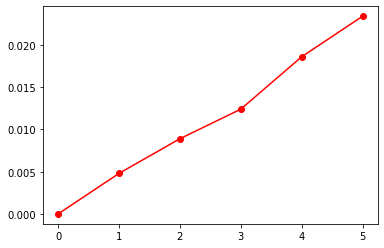

In [2]:

lambda_list = np.array([0, 1, 2, 3, 4, 5])
splitting_list = np.array([0, 0.0048, 0.0089, 0.0124, 0.0186, 0.0234])
plt.plot(lambda_list, splitting_list, 'r-o')
plt.show()

<a id=’Derivation’></a>
### Derivation

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$ with associated energy eigenvalue $0$
and one photon in the cavity, denoted by $|1\rangle$ with associated energy eigenvalue $\hbar \omega$.  Note that essentially shifts the photon Hamiltonian by the zero-point energy $\hbar \frac{\omega}{2}$.
We will model this system with a generalized Rabi Hamiltonian that can be written as:

$$ \hat{H} = E_g(R) \hat{a}_g^{\dagger} \hat{a}_g + E_e(R) \hat{a}_e^{\dagger} \hat{a}_e + 
\hbar \omega \hat{b} \hat{b}^{\dagger}  + \hbar \lambda \cdot \mu_{ge}(R) \left(\hat{b} + \hat{b}^{\dagger} \right) \left( \hat{a}_e^{\dagger} \hat{a}_g +  \hat{a}_g^{\dagger} \hat{a}_e\right). $$
The polaritonic potential energy surfaces may be obtained by building a Hamiltonian matrix in the following basis and diagonalizing as a function of the bond length $R$: $ |\phi\rangle \in \{|g,0\rangle , |g,1\rangle , |e,0\rangle, |e,1\rangle \}. $

#### Review of rules for the second quantized operators

The operators molecular electronic creation and annihilation operators $\hat{a}^{\dagger}_p$ and $\hat{a}_p$ act on the molecular electronic basis functions, and the the photonic raising and lowering operators $\hat{b}^{\dagger}$ and 
$\hat{b}$ act on the photonic basis functions.  The molecular electronic annihilation operators obey:
\begin{align}
\hat{a}_g|g\rangle = |\rangle \\
\hat{a}_e|e\rangle = |\rangle \\
\hat{a}_e|\rangle = 0 \\
\hat{a}_g|\rangle = 0 \\
\hat{a}_e|g\rangle = 0 \\
\hat{a}_g|e\rangle = 0
\end{align}
where $|\rangle$ denotes a vacuum Fock state.  

The molecular electronic creation operators obey:
\begin{align}
\hat{a}_g^{\dagger}|\rangle = |g\rangle \\
\hat{a}_e^{\dagger}|\rangle = |e\rangle \\
\hat{a}_g^{\dagger}|g\rangle = 0 \\
\hat{a}_e^{\dagger}|e\rangle = 0 
\end{align}

##### Question 1: Combine these rules to evaluate the following:
\begin{align}
\hat{a}_g^{\dagger}\hat{a}_e|e\rangle \\
\hat{a}_e^{\dagger}\hat{a}_g|g\rangle \\
\hat{a}_g^{\dagger}\hat{a}_e|g\rangle \\
\hat{a}_e^{\dagger}\hat{a}_g|e\rangle 
\end{align}

The photonic raising operators generally obey $\hat{b}^{\dagger}|n\rangle = \sqrt{n+1}|n+1\rangle$,
where $n$ denotes the number of photons that occupy the cavity.  
For the basis states in question, we have the following:
\begin{align}
\hat{b}^{\dagger}|0\rangle = |1\rangle \\
\hat{b}^{\dagger}|1\rangle = \sqrt{2}|2\rangle
\end{align}
where $|\rangle$ denotes a fermionic Fock vacuum state.

The photonic lowering operators generally obey $\hat{b}|n\rangle = \sqrt{n}|n-1\rangle$, so for the
basis states in question, we have:
\begin{align}
\hat{b}|1\rangle = |0\rangle \\
\hat{b}|0\rangle = 0.
\end{align}

##### Question 2: Combine the molecular and photonic creation and annihilation operator rules to derive elements of the Hamiltonian matrix

This matrix as a function of the bond-length $R$ is as follows:
\begin{equation}
{\bf H}(R)
  \mbox{=} 
  \begin{array}{c|cccc}
       & |g,0\rangle & |g,1\rangle & |e,0\rangle \\
    \hline
    \langle g,0| & E_g(R) + \frac{1}{2}\hbar \omega   &     0   & 0  \\
    \langle g,1| & 0        &   E_g(R) +  \frac{3}{2}\hbar \omega  & \hbar g(R) \\
    \langle e,0| & 0        &    \hbar g(R)  & E_e(R) + \frac{1}{2}\hbar \omega\\
  \end{array}
\end{equation}